In [2]:
# Load images and labels
import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

# # Define the input directory
input_dir = '/Users/odys/Desktop/ML_LOCAL_MAC/archive_small'

# Initialize lists to store images and labels
images = []
labels = []

# Loop through each folder (class name) in the input directory
for category in os.listdir(input_dir):
    category_path = os.path.join(input_dir, category)
    if os.path.isdir(category_path):  # Ensure it's a directory
        for file_name in os.listdir(category_path):
            if file_name.endswith('.jpeg') or file_name.endswith('.png'):  # Check for valid image files
                img_path = os.path.join(category_path, file_name)
                try:
                    # Open and preprocess the image
                    img = Image.open(img_path)
                    # img = img.resize((128, 128))  # Resize to 128x128
                    img_array = np.array(img)
                    
                    # Append the image and its label
                    images.append(img_array)
                    labels.append(category)  # Use the folder name as the label
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Print some information about the loaded data
print(f"Loaded {len(images)} images.")
print(f"Image shape: {images[0].shape} ")
print(f"Labels: {np.unique(labels)}")


Loaded 600 images.
Image shape: (64, 64) 
Labels: ['AbdomenCT' 'BreastMRI' 'Hand' 'HeadCT']


In [3]:
from sklearn.model_selection import train_test_split

# Set random_state for reproducibility
random_state = 42

# First, split into train and temp (test+val)
X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels, test_size=0.3, random_state=random_state, stratify=labels
)

# Then split temp into validation and test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=random_state, stratify=y_temp
)

print(f"Shape Train set: {X_train.shape}, labels: {y_train.shape}")
print(f"Shape Validation set: {X_val.shape}, labels: {y_val.shape}")
print(f"Shape Test set: {X_test.shape}, labels:{y_test.shape}")

Shape Train set: (420, 64, 64), labels: (420,)
Shape Validation set: (90, 64, 64), labels: (90,)
Shape Test set: (90, 64, 64), labels:(90,)


In [4]:
# LDA (Linear Discriminant Analysis) 

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

# Flatten images for LDA
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Standardize features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_flat)
X_val_std = scaler.transform(X_val_flat)
X_test_std = scaler.transform(X_test_flat)

# Number of LDA components (at most n_classes - 1)
n_classes = len(np.unique(y_train))
n_components = n_classes - 1

# Fit LDA on training data
lda = LinearDiscriminantAnalysis(n_components=n_components)
X_train_lda = lda.fit_transform(X_train_std, y_train)
X_val_lda = lda.transform(X_val_std)
X_test_lda = lda.transform(X_test_std)

print("LDA reduced train shape:", X_train_lda.shape)
print("LDA reduced test shape:", X_test_lda.shape)

LDA reduced train shape: (420, 3)
LDA reduced test shape: (90, 3)


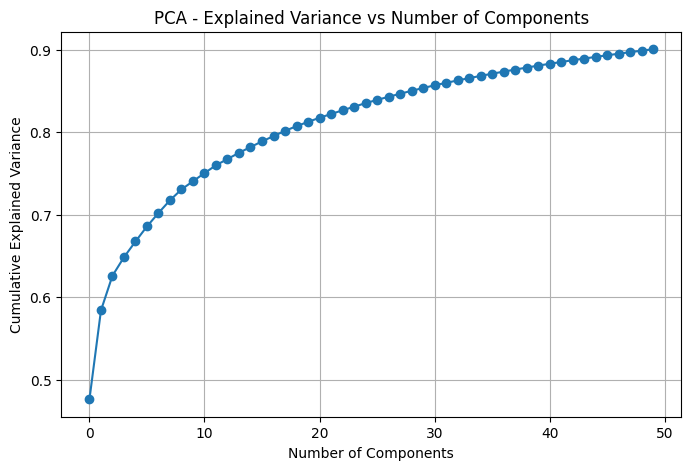

Original shape: (420, 4096)
PCA reduced shape: (420, 50)


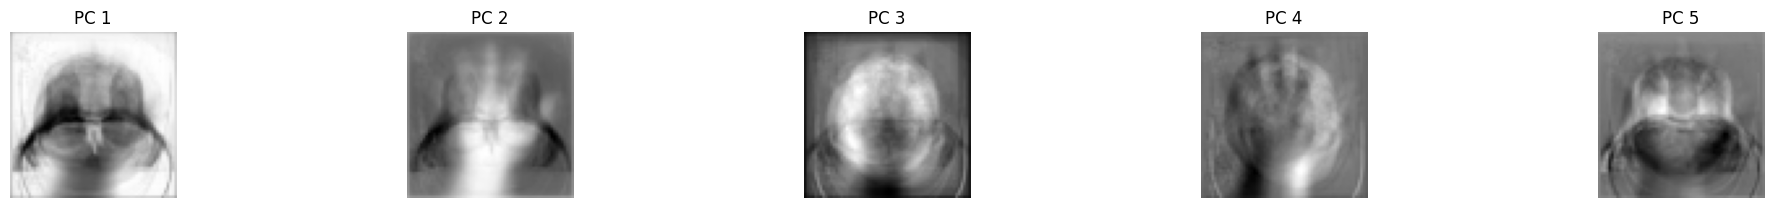

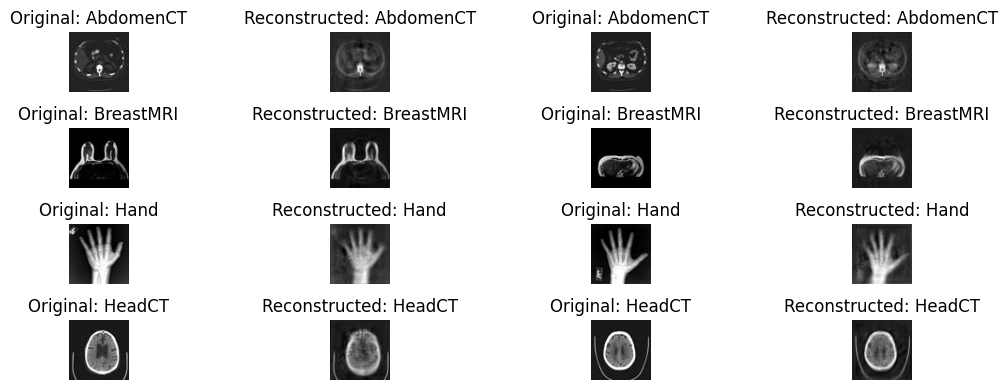

In [5]:
# PCA and visualization

import os
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt



# Flatten images for PCA
num_samples = X_train.shape[0]
flattened_images = X_train.reshape(num_samples, -1)

# Standardize
scaler = StandardScaler()
flattened_images_std = scaler.fit_transform(flattened_images)

# Apply PCA
# If you apply PCA on the whole data (including the test data) before training the model,
# then you in fact use some information from the test data.
# Thus, you cannot really judge the behaviour of your model using the test data,
# because it is not an unseen data anymore.
n_components = 50
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(flattened_images_std)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance vs Number of Components')
plt.grid(True)
plt.show()

print(f"Original shape: {flattened_images.shape}")
print(f"PCA reduced shape: {principal_components.shape}")

# Plot the first 5 principal components
plt.figure(figsize=(20, 4))
for i in range(5):     
    plt.subplot(2, 5, i + 1)
    component = pca.components_[i].reshape(X_train[0].shape)
    plt.imshow(component, cmap='gray')
    plt.title(f'PC {i + 1}')
    plt.axis('off')
plt.tight_layout()
plt.show()
# Plot the first 5 images of the training set
# Inverse transform to reconstruct images from PCA
reconstructed = pca.inverse_transform(principal_components)
reconstructed_images = scaler.inverse_transform(reconstructed)
reconstructed_images = reconstructed_images.reshape(X_train.shape)

# Plot 2 images per class: original vs reconstructed
unique_classes = np.unique(y_train)
images_per_class = 2

plt.figure(figsize=(10, 4))  # Bigger images

plot_idx = 1
for class_label in unique_classes:
    # Find indices for this class
    class_indices = np.where(y_train == class_label)[0][:images_per_class]
    for i, idx in enumerate(class_indices):
        plt.subplot(len(unique_classes), images_per_class * 2, plot_idx)
        plt.imshow(X_train[idx], cmap='gray')
        plt.title(f"Original: {class_label}")
        plt.axis('off')
        plot_idx += 1

        plt.subplot(len(unique_classes), images_per_class * 2, plot_idx)
        plt.imshow(reconstructed_images[idx], cmap='gray')
        plt.title(f"Reconstructed: {class_label}")
        plt.axis('off')
        plot_idx += 1

plt.tight_layout()
plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.show()
# ...existing code...

t-SNE output shape: (420, 2)


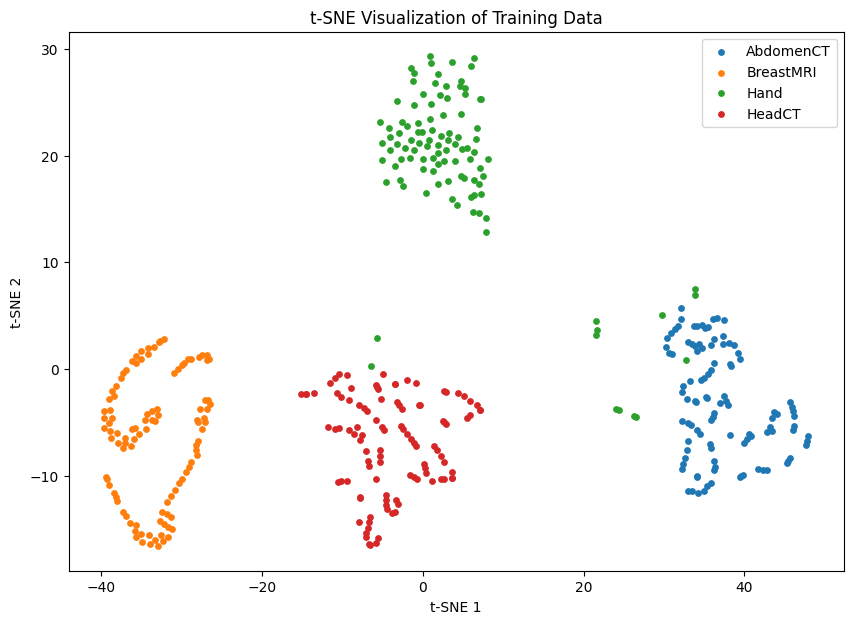

In [6]:
# T-sne only useful for visualization

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Flatten and standardize the training images
num_samples = X_train.shape[0]
flattened_images = X_train.reshape(num_samples, -1)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
flattened_images_std = scaler.fit_transform(flattened_images)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(flattened_images_std)
print("t-SNE output shape:", X_tsne.shape)

# Plot t-SNE result, colored by class
plt.figure(figsize=(10, 7))
for class_label in np.unique(y_train):
    idx = np.where(y_train == class_label)
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], label=class_label, s=15)
plt.title("t-SNE Visualization of Training Data")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.show()

In [7]:
# Logistic regression whithot PCA

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Flatten images for classification
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Standardize features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_flat)
X_val_std = scaler.transform(X_val_flat)
X_test_std = scaler.transform(X_test_flat)

# Train logistic regression classifier
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_std, y_train)

# Predict on test set
y_pred = clf.predict(X_test_std)

# Evaluate
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00        23
   BreastMRI       1.00      1.00      1.00        22
        Hand       1.00      1.00      1.00        23
      HeadCT       1.00      1.00      1.00        22

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



In [8]:
# just checkig 
num_samples = X_train.shape[0]
print(f"Number of samples: {num_samples}")
print("---------------------------------------")
flattened_images = X_train.reshape(num_samples, -1)
print(f"Flattened images shape: {flattened_images.shape}")
print("---------------------------------------")
print("pricipal components shape: ", principal_components.shape)
print("---------------------------------------")   
print("principal components=",principal_components)

Number of samples: 420
---------------------------------------
Flattened images shape: (420, 4096)
---------------------------------------
pricipal components shape:  (420, 50)
---------------------------------------
principal components= [[ -3.50979662  33.94851744  -4.93214616 ...   0.59212734   0.08578112
    2.59320418]
 [-47.17566082 -26.60748172   0.74742757 ...   0.90577107   5.32613863
   -1.15960428]
 [-21.89714978  36.11524547  -6.08630035 ...   0.53697398  -1.27469402
   -0.34616204]
 ...
 [-18.57188144   3.0953842    7.22013594 ...   4.81637984   4.7882039
    0.9737124 ]
 [-49.37657479 -23.50841011   0.66355941 ...   2.27248454   0.57461661
   -0.16839593]
 [-10.29723124  10.07390417  23.19739641 ...  -2.53384332   0.29533336
   -6.73336414]]


In [9]:
# Logistic regreression which uses PCA

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Flatten and standardize validation and test sets using the same scaler as training
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
X_val_std = scaler.transform(X_val_flat)
X_test_std = scaler.transform(X_test_flat)

# Apply PCA transformation using the same PCA fitted on training data
X_val_pca = pca.transform(X_val_std)
X_test_pca = pca.transform(X_test_std)

# Use PCA-reduced features for training
X_train_pca = principal_components  # Already computed for training set

# Train multiclass logistic regression classifier
clf = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
clf.fit(X_train_pca, y_train)

# Predict on test set
y_pred = clf.predict(X_test_pca)

# Evaluate
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00        23
   BreastMRI       1.00      1.00      1.00        22
        Hand       1.00      1.00      1.00        23
      HeadCT       1.00      1.00      1.00        22

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



/Users/odys/Desktop/ML_LOCAL_MAC/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [10]:
# Logistic regreression which uses LDA

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score


# Train multiclass logistic regression classifier
clf = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
clf.fit(X_train_lda, y_train)

# Predict on test set
y_pred = clf.predict(X_test_lda)

# Evaluate
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

/Users/odys/Desktop/ML_LOCAL_MAC/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00        23
   BreastMRI       1.00      1.00      1.00        22
        Hand       1.00      1.00      1.00        23
      HeadCT       1.00      1.00      1.00        22

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



In [11]:
# Classification SVM without PCA

from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Flatten images for classification
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Standardize features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_flat)
X_val_std = scaler.transform(X_val_flat)
X_test_std = scaler.transform(X_test_flat)

# Train SVM on PCA-reduced features
svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_clf.fit(X_train_std, y_train)

# Predict on test set
y_pred = svm_clf.predict(X_test_std)

# Evaluate
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nSVM Classification Report:\n", classification_report(y_test, y_pred))

SVM Test Accuracy: 1.0

SVM Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00        23
   BreastMRI       1.00      1.00      1.00        22
        Hand       1.00      1.00      1.00        23
      HeadCT       1.00      1.00      1.00        22

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



In [12]:
# Classification SVM with PCA

from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Train SVM on PCA-reduced features
svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_clf.fit(X_train_pca, y_train)

# Predict on test set
y_pred = svm_clf.predict(X_test_pca)

# Evaluate
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nSVM Classification Report:\n", classification_report(y_test, y_pred))

SVM Test Accuracy: 1.0

SVM Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00        23
   BreastMRI       1.00      1.00      1.00        22
        Hand       1.00      1.00      1.00        23
      HeadCT       1.00      1.00      1.00        22

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



In [13]:
# Classification SVM with LDA

from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Train SVM on PCA-reduced features
svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_clf.fit(X_train_lda, y_train)

# Predict on test set
y_pred = svm_clf.predict(X_test_lda)

# Evaluate
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nSVM Classification Report:\n", classification_report(y_test, y_pred))

SVM Test Accuracy: 1.0

SVM Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00        23
   BreastMRI       1.00      1.00      1.00        22
        Hand       1.00      1.00      1.00        23
      HeadCT       1.00      1.00      1.00        22

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



In [14]:
# KNN classification without PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Flatten images for classification
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Standardize features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_flat)
X_val_std = scaler.transform(X_val_flat)
X_test_std = scaler.transform(X_test_flat)

# Create and train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust n_neighbors
knn.fit(X_train_std, y_train)

# Predict on test set
y_pred = knn.predict(X_test_std)

# Evaluate
print("KNN Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nKNN Classification Report:\n", classification_report(y_test, y_pred))

KNN Test Accuracy: 0.9666666666666667

KNN Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       0.88      1.00      0.94        23
   BreastMRI       1.00      1.00      1.00        22
        Hand       1.00      0.87      0.93        23
      HeadCT       1.00      1.00      1.00        22

    accuracy                           0.97        90
   macro avg       0.97      0.97      0.97        90
weighted avg       0.97      0.97      0.97        90



In [15]:
# KNN classification with PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Use PCA-reduced features for training and testing
# X_train_pca, X_test_pca, y_train, y_test should already be defined

# Create and train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust n_neighbors
knn.fit(X_train_pca, y_train)

# Predict on test set
y_pred = knn.predict(X_test_pca)

# Evaluate
print("KNN Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nKNN Classification Report:\n", classification_report(y_test, y_pred))

KNN Test Accuracy: 0.9777777777777777

KNN Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       0.92      1.00      0.96        23
   BreastMRI       1.00      1.00      1.00        22
        Hand       1.00      0.91      0.95        23
      HeadCT       1.00      1.00      1.00        22

    accuracy                           0.98        90
   macro avg       0.98      0.98      0.98        90
weighted avg       0.98      0.98      0.98        90



In [16]:
# KNN classification with LDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Create and train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust n_neighbors
knn.fit(X_train_lda, y_train)

# Predict on test set
y_pred = knn.predict(X_test_lda)

# Evaluate
print("KNN Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nKNN Classification Report:\n", classification_report(y_test, y_pred))

KNN Test Accuracy: 1.0

KNN Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00        23
   BreastMRI       1.00      1.00      1.00        22
        Hand       1.00      1.00      1.00        23
      HeadCT       1.00      1.00      1.00        22

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90

